# Question 2: Training Model

In [1]:
import time

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext.data as data
from models.attention import MultiHeadAttention
from models.embedder import Embedder, FeedForward, Norm, PositionalEncoder, get_clones
from transformers import GPT2Tokenizer

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


## Decoder

In [3]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.dropout_1 = nn.Dropout(dropout)
        self.attn_1 = MultiHeadAttention(heads, d_model, dropout=dropout)
        self.ff = FeedForward(d_model, dropout=dropout)
        self.norm_2 = Norm(d_model)
        self.dropout_2 = nn.Dropout(dropout)

    def forward(self, x, trg_mask):
        x2 = self.norm_1(x)
        x = x + self.dropout_1(self.attn_1(x2, x2, x2, trg_mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.ff(x2))
        return x

In [4]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads, dropout):
        super().__init__()
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model, dropout=dropout)
        self.layers = get_clones(DecoderLayer(d_model, heads, dropout), N)
        self.norm = Norm(d_model)

    def forward(self, trg, trg_mask):
        x = self.embed(trg)
        x = self.pe(x)
        for layer in self.layers:
            x = layer(x, trg_mask)
        return self.norm(x)

## Transformer

In [5]:
class Transformer(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads, dropout, device):
        super().__init__()
        self.device = device
        self.vocab_size = vocab_size
        self.decoder = Decoder(vocab_size, d_model, N, heads, dropout)
        self.out = nn.Linear(d_model, vocab_size)

    def forward(self, trg, trg_mask):
        d_output = self.decoder(trg, trg_mask)
        output = self.out(d_output)
        return output

## No-Peak Mask

In [6]:
def nopeak_mask(size, device):
    np_mask = torch.triu(torch.ones((1, size, size), device=device), 1).bool()
    return np_mask


def create_src_mask(src, pad_token_id, device):
    src_mask = (src != pad_token_id).unsqueeze(-2)
    return src_mask

## Data Feeder

### Tokenizer

In [7]:
TOKENIZER = GPT2Tokenizer.from_pretrained("gpt2")

In [8]:
TOKENIZER.add_special_tokens(
    {"pad_token": "[PAD]", "bos_token": "<sos>", "eos_token": "<eos>"}
)
TOKENIZER.pad_token_id, TOKENIZER.bos_token_id, TOKENIZER.eos_token_id

(50257, 50258, 50259)

In [9]:
def tokenize(text):
    tokens = TOKENIZER.encode(
        text,
        add_special_tokens=True,
        max_length=512,  # sequence length
        truncation=True,
    )
    return tokens

In [10]:
def load_dataset(path):
    examples = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            if line.strip():
                src_line = line.strip()
                examples.append(data.Example.fromlist([src_line], [("src", SRC)]))
    dataset = data.Dataset(examples, [("src", SRC)])
    return dataset

### BucketIterator

In [11]:
SRC = data.Field(
    use_vocab=False,
    tokenize=tokenize,
    pad_token=TOKENIZER.pad_token_id,
    unk_token=TOKENIZER.unk_token_id,
    init_token=TOKENIZER.bos_token_id,
    eos_token=TOKENIZER.eos_token_id,
    lower=False,
    batch_first=True,
    fix_length=512,
)

In [12]:
train_data = load_dataset("data/wiki2.train.txt")

In [14]:
valid_data = load_dataset("data/wiki2.valid.txt")

## Training

In [15]:
def get_model(vocab_size, d_model=512, N=6, heads=8, dropout=0.1, device="cpu"):
    """Initialize and return the Transformer model

    Args:
        vocab_size (int): The size of the vocabulary.
        d_model (int): The dimensionality of the model.
        N (int): The number of decoder layers.
        heads (int): The number of attention heads.
        dropout (float): The dropout rate.

    Returns:
        Transformer: The initialized Transformer model.
    """
    model = Transformer(vocab_size, d_model, N, heads, dropout, device)
    model.to(device)
    return model

In [16]:
def train_model(
    model, train_iterator, valid_iterator, optimizer, device, epochs, print_every=50
):
    train_losses = []
    train_perplexities = []
    valid_losses = []
    valid_perplexities = []

    for epoch in range(epochs):
        # Training Phase
        model.train()
        total_train_loss = 0
        intermediate_train_loss = 0
        start = time.time()

        for i, batch in enumerate(train_iterator):
            src = batch.src.to(device)
            src_mask = create_src_mask(src, TOKENIZER.pad_token_id, device)
            no_peak_mask = nopeak_mask(src.size(1), device)

            # https://github.com/SamLynnEvans/Transformer/blob/master/Batch.py#L20
            preds = model(src, src_mask & no_peak_mask)
            preds = preds[:, :-1, :]  # exclude the last time step predictions
            ys = src[:, 1:].contiguous().view(-1)  # Targets shifted by one position

            optimizer.zero_grad()
            loss = F.cross_entropy(
                preds.reshape(-1, preds.size(-1)),
                ys,
                ignore_index=TOKENIZER.pad_token_id,
            )
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            intermediate_train_loss += loss.item()

            if (i + 1) % print_every == 0:
                p = int(100 * (i + 1) / len(train_iterator))
                avg_loss = intermediate_train_loss / print_every
                print(
                    f"{(time.time() - start) // 60}m: epoch {epoch + 1} [{p}%] Train loss = {avg_loss:.3f}",
                    end="\r",
                )
                intermediate_train_loss = 0

        avg_train_loss = total_train_loss / len(train_iterator)
        train_perplexity = torch.exp(torch.tensor(avg_train_loss)).item()
        train_losses.append(avg_train_loss)
        train_perplexities.append(train_perplexity)

        # Validation phase
        model.eval()
        total_valid_loss = 0
        with torch.no_grad():
            for i, batch in enumerate(valid_iterator):
                src = batch.src.to(device)
                src_mask = create_src_mask(src, TOKENIZER.pad_token_id, device)
                no_peak_mask = nopeak_mask(src.size(1), device)

                preds = model(src, src_mask & no_peak_mask)
                preds = preds[:, :-1, :]
                ys = src[:, 1:].contiguous().view(-1)

                loss = F.cross_entropy(
                    preds.reshape(-1, preds.size(-1)),
                    ys,
                    ignore_index=TOKENIZER.pad_token_id,
                )
                total_valid_loss += loss.item()

        avg_valid_loss = total_valid_loss / len(valid_iterator)
        valid_perplexity = torch.exp(torch.tensor(avg_valid_loss)).item()
        valid_losses.append(avg_valid_loss)
        valid_perplexities.append(valid_perplexity)

        print(
            f"Epoch {epoch + 1}: Train loss = {avg_train_loss:.3f}, Train Perplexity = {train_perplexity:.3f}"
        )
        print(
            f"Epoch {epoch + 1}: Validation loss = {avg_valid_loss:.3f}, Validation Perplexity = {valid_perplexity:.3f}"
        )

    return train_losses, train_perplexities, valid_losses, valid_perplexities

### Training the Model

In [17]:
train_iterator = data.BucketIterator(
    train_data,
    batch_size=25,
    device=DEVICE,
    sort=False,
    repeat=False,
)

In [18]:
valid_iterator = data.BucketIterator(
    valid_data,
    batch_size=25,
    device=DEVICE,
    sort=False,
    repeat=False,
)

In [19]:
vocab_size = len(TOKENIZER)
model = get_model(vocab_size, d_model=512, N=6, heads=8, dropout=0.1, device=DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [20]:
results = train_model(
    model, train_iterator, valid_iterator, optimizer, DEVICE, epochs=20, print_every=50
)

Epoch 1: Train loss = 4.196, Train Perplexity = 66.388
Epoch 1: Validation loss = 1.775, Validation Perplexity = 5.902
Epoch 2: Train loss = 2.324, Train Perplexity = 10.214
Epoch 2: Validation loss = 1.047, Validation Perplexity = 2.850
Epoch 3: Train loss = 1.943, Train Perplexity = 6.976
Epoch 3: Validation loss = 0.867, Validation Perplexity = 2.380
Epoch 4: Train loss = 1.600, Train Perplexity = 4.952
Epoch 4: Validation loss = 0.621, Validation Perplexity = 1.861
Epoch 5: Train loss = 1.611, Train Perplexity = 5.010
Epoch 5: Validation loss = 0.686, Validation Perplexity = 1.986
Epoch 6: Train loss = 1.678, Train Perplexity = 5.353
Epoch 6: Validation loss = 0.552, Validation Perplexity = 1.737
Epoch 7: Train loss = 1.223, Train Perplexity = 3.399
Epoch 7: Validation loss = 0.427, Validation Perplexity = 1.532
Epoch 8: Train loss = 0.918, Train Perplexity = 2.505
Epoch 8: Validation loss = 0.404, Validation Perplexity = 1.498
Epoch 9: Train loss = 1.303, Train Perplexity = 3.680


```python
Epoch 1: Train loss = 4.196, Train Perplexity = 66.388
Epoch 1: Validation loss = 1.775, Validation Perplexity = 5.902
Epoch 2: Train loss = 2.324, Train Perplexity = 10.214
Epoch 2: Validation loss = 1.047, Validation Perplexity = 2.850
Epoch 3: Train loss = 1.943, Train Perplexity = 6.976
Epoch 3: Validation loss = 0.867, Validation Perplexity = 2.380
Epoch 4: Train loss = 1.600, Train Perplexity = 4.952
Epoch 4: Validation loss = 0.621, Validation Perplexity = 1.861
Epoch 5: Train loss = 1.611, Train Perplexity = 5.010
Epoch 5: Validation loss = 0.686, Validation Perplexity = 1.986
Epoch 6: Train loss = 1.678, Train Perplexity = 5.353
Epoch 6: Validation loss = 0.552, Validation Perplexity = 1.737
Epoch 7: Train loss = 1.223, Train Perplexity = 3.399
Epoch 7: Validation loss = 0.427, Validation Perplexity = 1.532
Epoch 8: Train loss = 0.918, Train Perplexity = 2.505
Epoch 8: Validation loss = 0.404, Validation Perplexity = 1.498
Epoch 9: Train loss = 1.303, Train Perplexity = 3.680
Epoch 9: Validation loss = 0.337, Validation Perplexity = 1.401
Epoch 10: Train loss = 0.952, Train Perplexity = 2.592
Epoch 10: Validation loss = 0.380, Validation Perplexity = 1.463
Epoch 11: Train loss = 0.644, Train Perplexity = 1.904
Epoch 11: Validation loss = 0.280, Validation Perplexity = 1.323
Epoch 12: Train loss = 0.751, Train Perplexity = 2.119
Epoch 12: Validation loss = 0.262, Validation Perplexity = 1.299
Epoch 13: Train loss = 0.667, Train Perplexity = 1.949
Epoch 13: Validation loss = 0.297, Validation Perplexity = 1.346
Epoch 14: Train loss = 0.773, Train Perplexity = 2.167
Epoch 14: Validation loss = 0.249, Validation Perplexity = 1.283
Epoch 15: Train loss = 0.823, Train Perplexity = 2.277
Epoch 15: Validation loss = 0.214, Validation Perplexity = 1.239
Epoch 16: Train loss = 0.798, Train Perplexity = 2.222
Epoch 16: Validation loss = 0.266, Validation Perplexity = 1.305
Epoch 17: Train loss = 0.749, Train Perplexity = 2.115
Epoch 17: Validation loss = 0.195, Validation Perplexity = 1.216
Epoch 18: Train loss = 0.599, Train Perplexity = 1.820
Epoch 18: Validation loss = 0.208, Validation Perplexity = 1.231
Epoch 19: Train loss = 0.600, Train Perplexity = 1.822
Epoch 19: Validation loss = 0.244, Validation Perplexity = 1.276
Epoch 20: Train loss = 0.705, Train Perplexity = 2.024
Epoch 20: Validation loss = 0.219, Validation Perplexity = 1.245
```

Note that our losses and perplexities are very low.

In [28]:
train_losses, train_perplexities, valid_losses, valid_perplexities = results

## Hyperparameters

* `d_model` = 512:
    * Dimensionality of the embedding space.
    * also used as the size of the hidden layers
* `N` = 6:
    * number of decoder layers in the transformer model
    * More layers generally provide more representational power
* `heads` = 8:
    * number of parallel attention layers or "heads"
    * Multiple heads allow the model to simultaneously attend to information from different representation subspaces at different positions, improving the learning of dependencies
    * Eight is what's usually used in practice
* `dropout` = 0.1:
    * regularization technique where randomly selected neurons are ignored during training, reducing the risk of overfitting
    * helps prevent the model from becoming too dependent on any single neuron
* `lr` = 0.001:
    * controls how much to change the model in response to the estimated error each time the model weights are updated
    * a small learning rate is a common starting point
    * generally low enough to allow for stable training but not so low that training becomes too slow
* `batch_size` = 25:
    * Number of training examples used in one iteration
    * This is the maximum we were able to accomodate in our `NVIDIA A10G` (24 GB).
* Due to limited compute:
    * we can only test one set of hyperparams.
    * we chose the recommended hyperparams in the exercise.
    * This gave us excellent perplexity with the GPT-2 tokenizer.

### Training Results

In [29]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [30]:
epochs = list(range(1, len(train_losses) + 1))
train_data = pd.DataFrame(
    {
        "Epoch": epochs,
        "Train Loss": train_losses,
        "Train Perplexity": train_perplexities,
    }
)

valid_data = pd.DataFrame(
    {
        "Epoch": epochs,
        "Validation Loss": valid_losses,
        "Validation Perplexity": valid_perplexities,
    }
)

/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


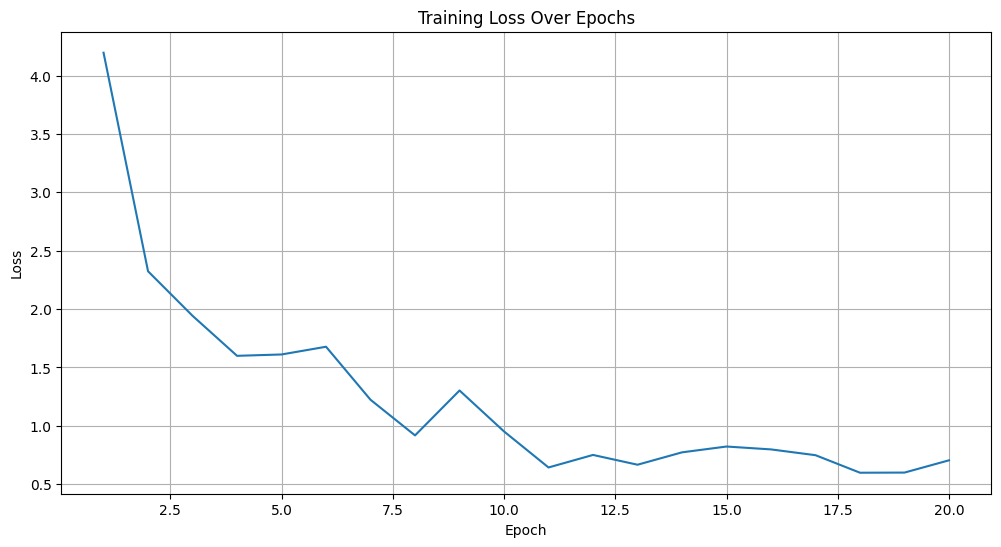

In [31]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=train_data, x="Epoch", y="Train Loss")
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


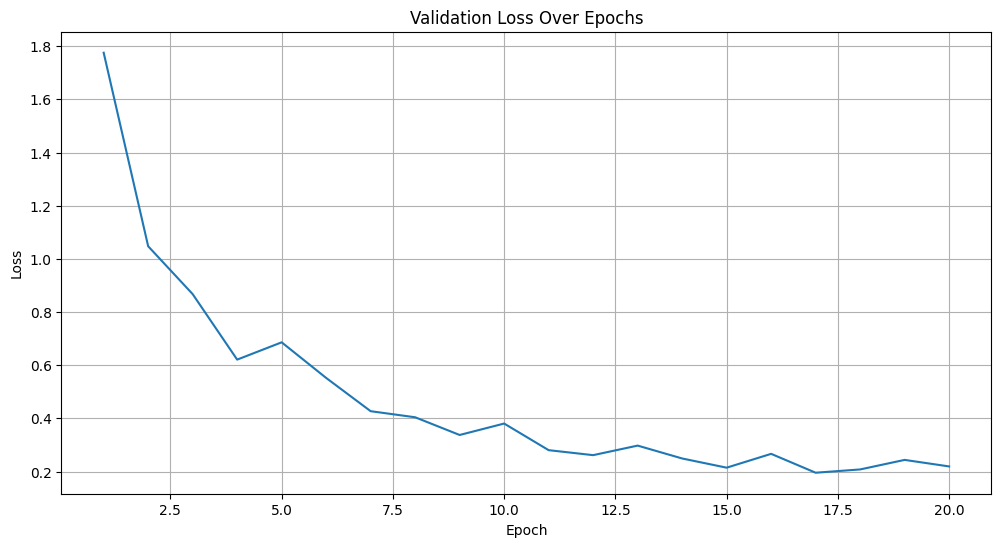

In [32]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=valid_data, x="Epoch", y="Validation Loss")
plt.title("Validation Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


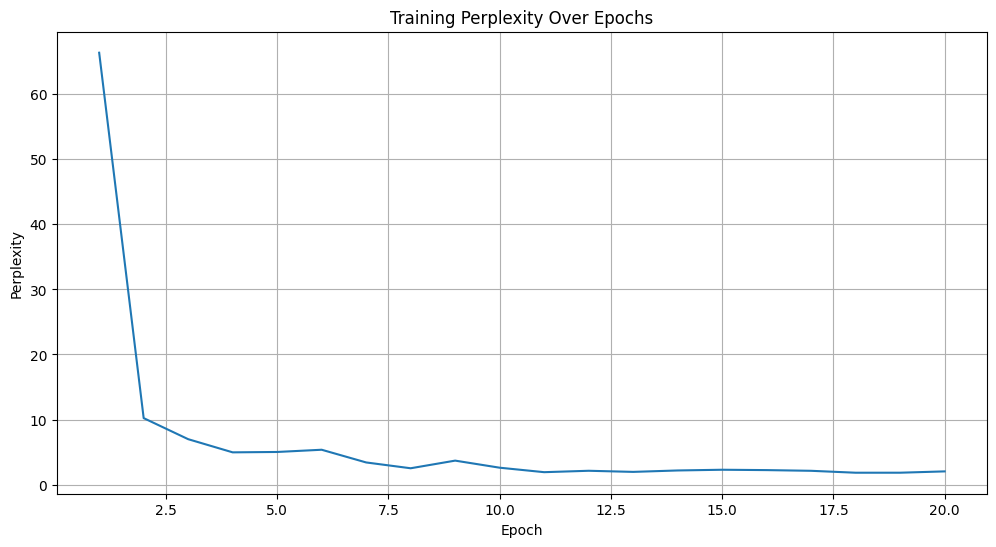

In [33]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=train_data, x="Epoch", y="Train Perplexity")
plt.title("Training Perplexity Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.grid(True)
plt.show()

/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


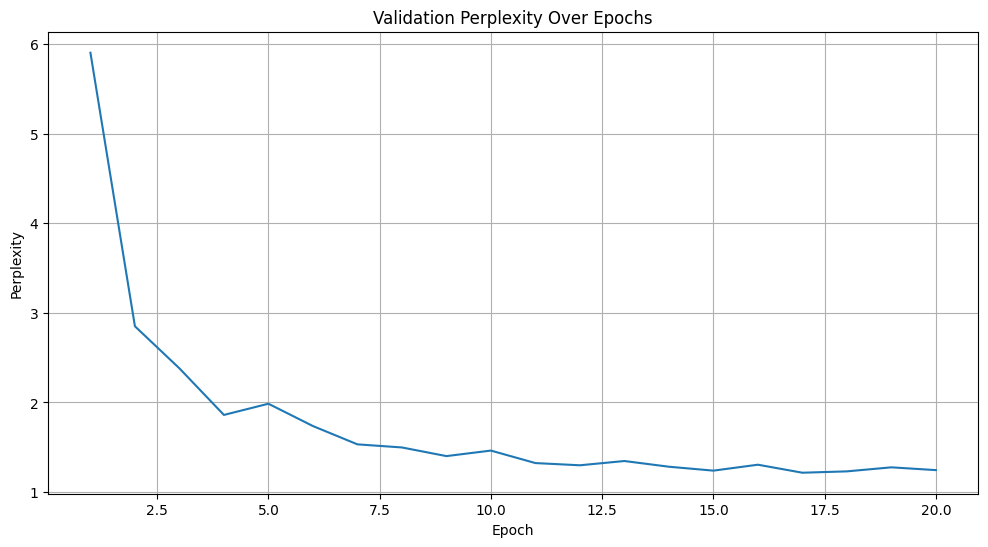

In [34]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=valid_data, x="Epoch", y="Validation Perplexity")
plt.title("Validation Perplexity Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.grid(True)
plt.show()

## Testing

In [37]:
torch.save(model.state_dict(), "model_wgts/model_weights.pth")

In [35]:
test_data = load_dataset("data/wiki2.test.txt")

In [36]:
test_iterator = data.BucketIterator(
    test_data,
    batch_size=25,
    device=DEVICE,
    sort=False,
    repeat=False,
)

In [42]:
def test_model(model, iterator, device):
    model.eval()
    total_test_loss = 0
    total_examples = 0

    with torch.no_grad():
        for batch in iterator:
            src = batch.src.to(device)
            src_mask = create_src_mask(src, TOKENIZER.pad_token_id, device)
            no_peak_mask = nopeak_mask(src.size(1), device)

            preds = model(src, src_mask & no_peak_mask)
            preds = preds[:, :-1, :]  # exclude the last time step predictions
            ys = (
                src[:, 1:].contiguous().view(-1)
            )  # Targets shifted by one position, assuming next-word prediction

            loss = F.cross_entropy(
                preds.reshape(-1, preds.size(-1)),
                ys,
                ignore_index=TOKENIZER.pad_token_id,
            )
            total_test_loss += loss.item()
            total_examples += src.size(0)

    avg_test_loss = total_test_loss / total_examples
    test_perplexity = torch.exp(torch.tensor(avg_test_loss)).item()

    return avg_test_loss, test_perplexity

In [43]:
loss, perplexity = test_model(model, test_iterator, DEVICE)

In [46]:
print("Average Loss:", loss)

Average Loss: 0.009466366565988288


In [48]:
print("Perplexity:", perplexity)

Perplexity: 1.0095113515853882


## Using Saved Weights

In [49]:
saved_model = get_model(
    vocab_size, d_model=512, N=6, heads=8, dropout=0.1, device=DEVICE
)

In [51]:
saved_model.load_state_dict(
    torch.load("model_wgts/model_weights.pth", map_location=DEVICE)
)

<All keys matched successfully>

In [58]:
def predict_next_token(text, model, tokenizer, device):
    token_ids = tokenizer.encode(text, return_tensors="pt")
    token_ids = token_ids.to(device)

    src_mask = create_src_mask(token_ids, tokenizer.pad_token_id, DEVICE)

    model.eval()

    with torch.no_grad():
        outputs = model(token_ids, src_mask)

    logits = outputs[0, -1, :]
    probs = torch.nn.functional.softmax(logits, dim=-1)
    predicted_token_id = torch.argmax(probs).item()

    predicted_token = tokenizer.decode([predicted_token_id])

    return predicted_token

In [65]:
def predict_next_n_tokens(text, model, tokenizer, device, n):
    for _ in range(n):
        next_token = predict_next_token(text, model, tokenizer, device)
        text += " " + next_token
    return text

In [72]:
text = """When Japan began the Pacific War on 8 December , the sisters sortied for the <unk> Islands with four other battleships and the light carrier <unk> as distant cover for the fleet attacking Pearl Harbor , and returned six days later . On 11 March 1942 <unk> and <unk> sortied from their anchorage at <unk> to join the unsuccessful search for the American carrier force that had attacked Marcus Island a week earlier . Similarly they pursued but did not catch the American carriers that had launched the <unk> Raid on 18 April . 
 During gunnery training on 5 May ,"""
n = 10

In [73]:
predicted_sequence = predict_next_n_tokens(text, model, TOKENIZER, DEVICE, n)
print("Extended sequence with predicted tokens:", predicted_sequence)

Extended sequence with predicted tokens: When Japan began the Pacific War on 8 December , the sisters sortied for the <unk> Islands with four other battleships and the light carrier <unk> as distant cover for the fleet attacking Pearl Harbor , and returned six days later . On 11 March 1942 <unk> and <unk> sortied from their anchorage at <unk> to join the unsuccessful search for the American carrier force that had attacked Marcus Island a week earlier . Similarly they pursued but did not catch the American carriers that had launched the <unk> Raid on 18 April . 
 During gunnery training on 5 May ,  and  the  game  had  been  can  be  very  on  the


Ground Truth:

```txt
When Japan began the Pacific War on 8 December , the sisters sortied for the <unk> Islands with four other battleships and the light carrier <unk> as distant cover for the fleet attacking Pearl Harbor , and returned six days later . On 11 March 1942 <unk> and <unk> sortied from their anchorage at <unk> to join the unsuccessful search for the American carrier force that had attacked Marcus Island a week earlier . Similarly they pursued but did not catch the American carriers that had launched the <unk> Raid on 18 April . 
 During gunnery training on 5 May , [there was a premature detonation in the left gun]
```

Albeit, not perfect, this is what our model predicts.